[Link a la carpeta con todo el TP](https://drive.google.com/drive/u/0/folders/1do-iyf2SzQln-fh8tmu9mSfzLuim5xs5)

Para corregir correr todo en orden menos el bloque param search. Me ha llegado a crashear por memoria si trato de correr todo de una, pero por alguna razón si corro todo en orden por separado no crashea

# Imports y obtención de archivos

In [ ]:
!pip install category_encoders

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from category_encoders import BinaryEncoder
import pandas as pd
import numpy as np
%matplotlib inline
import pyarrow.parquet as pq
import os
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from scipy.stats import uniform, randint
from sklearn.metrics import f1_score

pd.options.display.float_format = '{:20,.10f}'.format

import gc

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
if not os.path.exists('test.parq'):
  id1="1puQpPyRVtoX_MTPJITQEtQny8a714zXk"
  downloaded1 = drive.CreateFile({'id': id1})
  downloaded1.GetContentFile('test.parq')

if not os.path.exists('train.parq'):
  id2="1Tf5pfrYBk8yM6QzC5IWebtSlja3R5BwN"
  downloaded2 = drive.CreateFile({'id': id2})
  downloaded2.GetContentFile('train.parq')

# Init stage

load dataframe

In [ ]:
raw_df = pq.read_table('train.parq').to_pandas()
test_df = pq.read_table('test.parq').to_pandas()

drop duplicate columns and rows

In [ ]:
raw_df.drop(['watcher_as_num', 'attacker_as_num'], axis=1, inplace=True)
test_df.drop(['watcher_as_num', 'attacker_as_num'], axis=1, inplace=True)
raw_df.drop_duplicates(inplace=True)

Efficiency casts

In [ ]:
raw_df['watcher_uuid_enum'] = raw_df['watcher_uuid_enum'].astype('uint32')
test_df['watcher_uuid_enum'] = test_df['watcher_uuid_enum'].astype('uint32')

gc.collect()

4

Train/test split based on IPs

In [ ]:
# Create a DataFrame with unique IPs and their corresponding labels
ip_label_df = raw_df[['attacker_ip_enum', 'label']].drop_duplicates()

# Split the unique IPs into two sets with roughly 80%-20% proportions, stratified by label
train_ips, test_ips = train_test_split(ip_label_df['attacker_ip_enum'],
                                       test_size=0.2,
                                       random_state=42,
                                       stratify=ip_label_df['label'])

# Use these sets to filter the original DataFrame
train_df = raw_df[raw_df['attacker_ip_enum'].isin(train_ips)]
val_df = raw_df[raw_df['attacker_ip_enum'].isin(test_ips)]

del raw_df
del ip_label_df
gc.collect()


0

# Encoding stage

### just for sanity checks

In [ ]:
test_df.sample(3)

,attack_time,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,watcher_uuid_enum,attacker_ip_enum
1004600,2023-08-02 12:07:41+00:00,US,ASN-CXA-ALL-CCI-22773-RDC,NL,KPN B.V.,http:bruteforce,2265,13361
775079,2023-08-11 22:31:13+00:00,IL,O.m.c. Computers & Communications Ltd,IN,DIGITALOCEAN-ASN,http:spam,984,7696
675768,2023-08-17 09:48:13+00:00,GB,Simply Transit Ltd,TH,CS LOXINFO PUBLIC COMPANY LIMITED,http:scan,5086,6495


### IP is supposed to be different for new attackers, so doesn't matters

In [ ]:
train_df.drop(['attacker_ip_enum'], axis=1, inplace=True)
val_df.drop(['attacker_ip_enum'], axis=1, inplace=True)

test_ips = test_df['attacker_ip_enum'] # I'll need these for kaggle submission
test_df.drop(['attacker_ip_enum'], axis=1, inplace=True)

### Encode attack time: I only care about day of week and hour of attack

In [ ]:
test_df['attack_hour'] = test_df['attack_time'].dt.hour.astype('uint8')
test_df['attack_day'] = test_df['attack_time'].dt.day_name().astype('category')
test_df.drop('attack_time', axis=1, inplace=True)

train_df['attack_hour'] = train_df['attack_time'].dt.hour.astype('uint8')
train_df['attack_day'] = train_df['attack_time'].dt.day_name().astype('category')
train_df.drop('attack_time', axis=1, inplace=True)

val_df['attack_hour'] = val_df['attack_time'].dt.hour.astype('uint8')
val_df['attack_day'] = val_df['attack_time'].dt.day_name().astype('category')
val_df.drop('attack_time', axis=1, inplace=True)

gc.collect()

65

### AS Names (Mean/Target)

In [ ]:
target_encoder = TargetEncoder(cols=['watcher_as_name'])

train_df_encoded = target_encoder.fit_transform(train_df[['watcher_as_name']], train_df['label'])
test_df_encoded = target_encoder.transform(test_df[['watcher_as_name']])
val_df_encoded = target_encoder.transform(val_df[['watcher_as_name']])

train_df[['watcher_as_name']] = train_df_encoded.astype('float32').fillna(0)
test_df[['watcher_as_name']] = test_df_encoded.astype('float32').fillna(0)
val_df[['watcher_as_name']] = val_df_encoded.astype('float32').fillna(0)

del train_df_encoded, test_df_encoded, val_df_encoded, target_encoder
gc.collect()

0

In [ ]:
target_encoder = TargetEncoder(cols=['attacker_as_name'])

train_df_encoded = target_encoder.fit_transform(train_df[['attacker_as_name']], train_df['label'])
test_df_encoded = target_encoder.transform(test_df[['attacker_as_name']])
val_df_encoded = target_encoder.transform(val_df[['attacker_as_name']])

train_df[['attacker_as_name']] = train_df_encoded.astype('float32').fillna(0)
test_df[['attacker_as_name']] = test_df_encoded.astype('float32').fillna(0)
val_df[['attacker_as_name']] = val_df_encoded.astype('float32').fillna(0)

del train_df_encoded, test_df_encoded, val_df_encoded, target_encoder
gc.collect()

0

### Country encoding (mean)

In [ ]:
target_encoder = TargetEncoder(cols=['attacker_country'])

train_df_encoded = target_encoder.fit_transform(train_df[['attacker_country']], train_df['label'])
test_df_encoded = target_encoder.transform(test_df[['attacker_country']])
val_df_encoded = target_encoder.transform(val_df[['attacker_country']])

train_df[['attacker_country']] = train_df_encoded.astype('float32').fillna(0)
test_df[['attacker_country']] = test_df_encoded.astype('float32').fillna(0)
val_df[['attacker_country']] = val_df_encoded.astype('float32').fillna(0)

del train_df_encoded, test_df_encoded, val_df_encoded, target_encoder
gc.collect()

0

In [ ]:
target_encoder = TargetEncoder(cols=['watcher_country'])

train_df_encoded = target_encoder.fit_transform(train_df[['watcher_country']], train_df['label'])
test_df_encoded = target_encoder.transform(test_df[['watcher_country']])
val_df_encoded = target_encoder.transform(val_df[['watcher_country']])

train_df[['watcher_country']] = train_df_encoded.astype('float32').fillna(0)
test_df[['watcher_country']] = test_df_encoded.astype('float32').fillna(0)
val_df[['watcher_country']] = val_df_encoded.astype('float32').fillna(0)

del train_df_encoded, test_df_encoded, val_df_encoded, target_encoder
gc.collect()

0

### Watcher id encoding (mean)

In [ ]:
target_encoder = TargetEncoder(cols=['watcher_uuid_enum'])

train_df_encoded = target_encoder.fit_transform(train_df[['watcher_uuid_enum']], train_df['label'])
test_df_encoded = target_encoder.transform(test_df[['watcher_uuid_enum']])
val_df_encoded = target_encoder.transform(val_df[['watcher_uuid_enum']])

train_df[['watcher_uuid_enum']] = train_df_encoded.astype('float32').fillna(0)
test_df[['watcher_uuid_enum']] = test_df_encoded.astype('float32').fillna(0)
val_df[['watcher_uuid_enum']] = val_df_encoded.astype('float32').fillna(0)

del train_df_encoded, test_df_encoded, val_df_encoded, target_encoder
gc.collect()

0

### SIKE, Binary time

In [ ]:
# Initialize a BinaryEncoder for the 'attack_type' column
binary_encoder = BinaryEncoder(cols=['attack_type'])

# Fit and transform on the training data
train_df_encoded = binary_encoder.fit_transform(train_df[['attack_type']])

# Transform the test data
test_df_encoded = binary_encoder.transform(test_df[['attack_type']])
val_df_encoded = binary_encoder.transform(val_df[['attack_type']])

# Merge the encoded columns back into the original DataFrames
train_df = pd.concat([train_df, train_df_encoded], axis=1)
test_df = pd.concat([test_df, test_df_encoded], axis=1)
val_df = pd.concat([val_df, val_df_encoded], axis=1)

# Clean up unnecessary variables
del train_df_encoded, test_df_encoded, val_df_encoded
gc.collect()

# Drop the original 'attack_type' column
train_df.drop('attack_type', axis=1, inplace=True)
test_df.drop('attack_type', axis=1, inplace=True)
val_df.drop('attack_type', axis=1, inplace=True)

# Cast to uint8 for efficiency
train_df['attack_type_0'] = train_df['attack_type_0'].astype('uint8')
val_df['attack_type_0'] = val_df['attack_type_0'].fillna(0).astype('uint8')
test_df['attack_type_0'] = test_df['attack_type_0'].astype('uint8')

train_df['attack_type_1'] = train_df['attack_type_1'].astype('uint8')
val_df['attack_type_1'] = val_df['attack_type_1'].fillna(0).astype('uint8')
test_df['attack_type_1'] = test_df['attack_type_1'].astype('uint8')

train_df['attack_type_2'] = train_df['attack_type_2'].astype('uint8')
val_df['attack_type_2'] = val_df['attack_type_2'].fillna(0).astype('uint8')
test_df['attack_type_2'] = test_df['attack_type_2'].astype('uint8')

train_df['attack_type_3'] = train_df['attack_type_3'].astype('uint8')
val_df['attack_type_3'] = val_df['attack_type_3'].fillna(0).astype('uint8')
test_df['attack_type_3'] = test_df['attack_type_3'].astype('uint8')

In [ ]:
# Initialize a BinaryEncoder for the 'attack_type' column
binary_encoder = BinaryEncoder(cols=['attack_day'])

# Fit and transform on the training data
train_df_encoded = binary_encoder.fit_transform(train_df[['attack_day']])

# Transform the test data
test_df_encoded = binary_encoder.transform(test_df[['attack_day']])
val_df_encoded = binary_encoder.transform(val_df[['attack_day']])

# Merge the encoded columns back into the original DataFrames
train_df = pd.concat([train_df, train_df_encoded], axis=1)
test_df = pd.concat([test_df, test_df_encoded], axis=1)
val_df = pd.concat([val_df, val_df_encoded], axis=1)

# Clean up unnecessary variables
del train_df_encoded, test_df_encoded, val_df_encoded
gc.collect()

# Drop the original 'attack_day' column
train_df.drop('attack_day', axis=1, inplace=True)
test_df.drop('attack_day', axis=1, inplace=True)
val_df.drop('attack_day', axis=1, inplace=True)

# Cast to uint8 for efficiency
train_df['attack_day_0'] = train_df['attack_day_0'].astype('uint8')
test_df['attack_day_0'] = test_df['attack_day_0'].astype('uint8')
val_df['attack_day_0'] = val_df['attack_day_0'].fillna(0).astype('uint8')

train_df['attack_day_1'] = train_df['attack_day_1'].astype('uint8')
test_df['attack_day_1'] = test_df['attack_day_1'].astype('uint8')
val_df['attack_day_1'] = val_df['attack_day_1'].fillna(0).astype('uint8')

train_df['attack_day_2'] = train_df['attack_day_2'].astype('uint8')
test_df['attack_day_2'] = test_df['attack_day_2'].astype('uint8')
val_df['attack_day_2'] = val_df['attack_day_2'].fillna(0).astype('uint8')

In [ ]:
val_df


,watcher_country,watcher_as_name,attacker_country,attacker_as_name,watcher_uuid_enum,label,attack_hour,attack_type_0,attack_type_1,attack_type_2,attack_type_3,attack_day_0,attack_day_1,attack_day_2
18,0.0186903048,0.0257912595,0.0049664988,0.0003418816,0.0315070041,0,7,0,1,0,0,0,0,1
73,0.0155852009,0.0312232673,0.0021783540,0.0000000000,0.0602696277,0,7,0,0,1,0,0,0,1
74,0.0155852009,0.0312232673,0.0021783540,0.0000000000,0.0602696277,0,7,0,0,1,1,0,0,1
75,0.0168622956,0.0101951538,0.0000000000,0.0000000000,0.0000000000,0,7,0,0,1,1,0,0,1
77,0.0155852009,0.0312232673,0.0021783540,0.0000000000,0.0602696277,0,7,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61629648,0.0153542561,0.0037674613,0.0122935092,0.0000000000,0.0038139832,0,21,0,1,0,0,1,0,1
61629670,0.0186903048,0.0212951992,0.0228716712,0.0000000000,0.0567936748,0,21,0,0,1,0,1,0,1
61629671,0.0186903048,0.0212951992,0.0228716712,0.0000000000,0.0567936748,0,21,0,0,1,1,1,0,1
61629673,0.0186903048,0.0212951992,0.0228716712,0.0000000000,0.0567936748,0,21,0,1,0,0,1,0,1


### Save validation df to disk in prep for training

In [ ]:
test_df['attacker_ip_enum'] = test_ips
test_df.to_parquet("test_encoded.parq")
del test_df
gc.collect()

0

In [ ]:
train_df.to_parquet("train_processed.parq")
val_df.to_parquet("val_processed.parq")

In [ ]:
train_df = pq.read_table("train_processed.parq").to_pandas()
val_df = pq.read_table("val_processed.parq").to_pandas()

## Congratulations! You arrived at a checkpoint

In [ ]:
val_df.sample(3)

,watcher_country,watcher_as_name,attacker_country,attacker_as_name,watcher_uuid_enum,label,attack_hour,attack_type_0,attack_type_1,attack_type_2,attack_type_3,attack_day_0,attack_day_1,attack_day_2
54488529,0.0153542561,0.0597562976,0.0228716712,0.0000000000,0.0181818176,0,5,0,0,1,0,1,1,1
48961478,0.0186903048,0.0275943354,0.0101598157,0.0041842810,0.0000000000,0,6,0,0,0,1,1,1,1
39651959,0.0186903048,0.0280207936,0.0228716712,0.0000288600,0.0001620450,0,18,0,1,0,0,0,1,1


# Preceptron stage

### Param search

In [ ]:
# Define your features (X) and target (y)
X_train = train_df.drop('label', axis=1)  # Assuming 'label' is your target column
y_train = train_df['label']
X_test = val_df.drop('label', axis=1)
y_test = val_df['label']

# Define batch size for training
n_iter_search = 100000

cut = 0.3

lr_opt = ['constant', 'optimal', 'invscaling', 'adaptive']

for n_iter in range(n_iter_search):
  params = {
      'learning_rate': lr_opt[random.randint(0, len(lr_opt)-1)],
      'alpha': random.uniform(1e-6, 1e-3),
      'max_iter': random.randint(500, 5000),
      'eta0': random.uniform(0.0, 2.0),
      'n_iter_no_change': random.randint(5, 20),
      'tol': random.uniform(1e-10, 1e-3)
  }

  # Create an instance of the SGDClassifier with perceptron loss
  clf = SGDClassifier(loss='perceptron',
                      random_state=42,
                      learning_rate=params['learning_rate'],
                      alpha=params['alpha'],
                      max_iter=params['max_iter'],
                      eta0=params['eta0'],
                      n_iter_no_change=params['n_iter_no_change'],
                      tol=params['tol']
                      )

  # Train the model in batches
  clf.fit(X_train, y_train)

  # Predict on the test set
  y_pred = clf.predict(X_test)

  # Calculate the F1 score
  f1_accuracy = f1_score(y_test, y_pred)

  if (True):
    print("F1 Accuracy Score:", f1_accuracy)
    print("Hyperparameters:", params)



### Params found (part 2)

TO BEAT:

F1 Accuracy Score: 0.5424511504485773

Best Hyperparameters: {'max_iter': 1669, 'eta0': 0.018123426235869378, 'n_iter_no_change': 5}

---

seed 317

---

F1 Accuracy Score: 0.2754933524613409

Hyperparameters: {'learning_rate': 'constant', 'alpha': 7.406643392985361e-06, 'max_iter': 3494, 'eta0': 0.6717948808898, 'n_iter_no_change': 7, 'tol': 0.06728633309889819}

---

F1 Accuracy Score: 0.23738812836311932

Hyperparameters: {'learning_rate': 'constant', 'alpha': 6.627603046911494e-05, 'max_iter': 4128, 'eta0': 0.12692498161419907, 'n_iter_no_change': 17, 'tol': 0.0008856264353356112}

---
---
seed 42

---

F1 Accuracy Score: 0.4455498222293537

Hyperparameters: {'learning_rate': 'constant', 'alpha': 0.0001757621805073129, 'max_iter': 813, 'eta0': 0.15262045338396524, 'n_iter_no_change': 19, 'tol': 0.0009979514870358112}


---

F1 Accuracy Score: 0.544604745625285

Hyperparameters: {'learning_rate': 'constant', 'alpha': 0.0003470692075798991, 'max_iter': 4476, 'eta0': 0.2542231403935564, 'n_iter_no_change': 20, 'tol': 0.00016964196182250803}


1-2 dec night run

---

F1 Accuracy Score: 0.5329945548513055

Hyperparameters: {'learning_rate': 'adaptive', 'alpha': 0.0006919888551498117, 'max_iter': 2784, 'eta0': 1.001160806734021, 'n_iter_no_change': 9, 'tol': 4.527950595924093e-05}

---

F1 Accuracy Score: 0.5212080158058143

Hyperparameters: {'learning_rate': 'adaptive', 'alpha': 0.00032205445672940023, 'max_iter': 2058, 'eta0': 1.1019635896785498, 'n_iter_no_change': 8, 'tol': 0.00012594819926493934}

---

F1 Accuracy Score: 0.5392781011061065

Hyperparameters: {'learning_rate': 'adaptive', 'alpha': 0.00023318165733728153, 'max_iter': 1740, 'eta0': 1.2673963388862328, 'n_iter_no_change': 5, 'tol': 0.000642469698519743}

---
F1 Accuracy Score: 0.5377655331343989

Hyperparameters: {'learning_rate': 'optimal', 'alpha': 0.00030630197060340557, 'max_iter': 4506, 'eta0': 1.8713780750781357, 'n_iter_no_change': 18, 'tol': 0.00047122317585961604}

---

F1 Accuracy Score: 0.5105124310496443

Hyperparameters: {'learning_rate': 'constant', 'alpha': 3.7011050832026016e-05, 'max_iter': 2001, 'eta0': 0.0388771432635715, 'n_iter_no_change': 7, 'tol': 0.0001810125535694282}

---

F1 Accuracy Score: 0.5027816672500874

Hyperparameters: {'learning_rate': 'optimal', 'alpha': 0.0006030520933921223, 'max_iter': 1954, 'eta0': 1.8812063538246624, 'n_iter_no_change': 19, 'tol': 7.526552957527195e-05}

---

F1 Accuracy Score: 0.5146565676183078

Hyperparameters: {'learning_rate': 'optimal', 'alpha': 0.0005761077119925548, 'max_iter': 1559, 'eta0': 0.31717110807499593, 'n_iter_no_change': 5, 'tol': 0.00037218435308103415}

---

F1 Accuracy Score: 0.5226097569996672

Hyperparameters: {'learning_rate': 'invscaling', 'alpha': 0.0007470773724875336, 'max_iter': 4260, 'eta0': 1.9046994650469355, 'n_iter_no_change': 13, 'tol': 0.00031157561564778755}

---

F1 Accuracy Score: 0.5275095911514617

Hyperparameters: {'learning_rate': 'optimal', 'alpha': 0.0009308151283701781, 'max_iter': 4006, 'eta0': 0.37372028433738214, 'n_iter_no_change': 9, 'tol': 5.641592118914275e-05}

---

F1 Accuracy Score: 0.5319232516592712

Hyperparameters: {'learning_rate': 'invscaling', 'alpha': 0.0004771122699869666, 'max_iter': 4427, 'eta0': 0.5237899008038991, 'n_iter_no_change': 9, 'tol': 0.0005542930143805565}

---

F1 Accuracy Score: 0.5215150081754424

Hyperparameters: {'learning_rate': 'optimal', 'alpha': 0.0009903430433588045, 'max_iter': 3359, 'eta0': 0.927458844559758, 'n_iter_no_change': 11, 'tol': 0.0005144548248799042}

---

F1 Accuracy Score: 0.5319229826288093

Hyperparameters: {'learning_rate': 'optimal', 'alpha': 0.00043628095496591173, 'max_iter': 3063, 'eta0': 1.8712479692411683, 'n_iter_no_change': 20, 'tol': 0.0009956582083095042}

---

F1 Accuracy Score: 0.5201092840586238

Hyperparameters: {'learning_rate': 'optimal', 'alpha': 0.0008086331624992564, 'max_iter': 4982, 'eta0': 0.2292230925613301, 'n_iter_no_change': 11, 'tol': 0.0002830623552916368}

---

F1 Accuracy Score: 0.5377476223946753

Hyperparameters: {'learning_rate': 'adaptive', 'alpha': 0.000439959162307358, 'max_iter': 2873, 'eta0': 1.764763832255135, 'n_iter_no_change': 14, 'tol': 9.765834726950855e-05}

---

F1 Accuracy Score: 0.5042969006629145

Hyperparameters: {'learning_rate': 'optimal', 'alpha': 6.734601142091035e-05, 'max_iter': 3553, 'eta0': 1.0313970414176932, 'n_iter_no_change': 19, 'tol': 0.00028286245237968584}

---

F1 Accuracy Score: 0.5182683404423261
Hyperparameters: {'learning_rate': 'optimal', 'alpha': 0.0009922439666740289, 'max_iter': 2462, 'eta0': 1.2685232224634482, 'n_iter_no_change': 10, 'tol': 0.0009418087665431463}

---

F1 Accuracy Score: 0.5328863585287288

Hyperparameters: {'learning_rate': 'invscaling', 'alpha': 0.0009629241829191992, 'max_iter': 2681, 'eta0': 0.3620163186895211, 'n_iter_no_change': 19, 'tol': 0.0008038519975754004}

---

F1 Accuracy Score: 0.5145493802970578

Hyperparameters: {'learning_rate': 'invscaling', 'alpha': 0.00025731687228860853, 'max_iter': 3539, 'eta0': 0.29368052245612564, 'n_iter_no_change': 19, 'tol': 0.000429046513726976}

---

F1 Accuracy Score: 0.5417455355694244

Hyperparameters: {'learning_rate': 'adaptive', 'alpha': 1.0855512572639693e-05, 'max_iter': 4476, 'eta0': 1.1198162109101988, 'n_iter_no_change': 13, 'tol': 0.0003821205191404399}

---

F1 Accuracy Score: 0.5220241279099479

Hyperparameters: {'learning_rate': 'constant', 'alpha': 0.0006776305888959237, 'max_iter': 4032, 'eta0': 0.15739987122500598, 'n_iter_no_change': 15, 'tol': 0.0002963695906503804}

---
F1 Accuracy Score: 0.5160893214073986

Hyperparameters: {'learning_rate': 'adaptive', 'alpha': 0.00038222317891905075, 'max_iter': 4105, 'eta0': 0.535338196334505, 'n_iter_no_change': 13, 'tol': 0.0002506406219600588}

---

F1 Accuracy Score: 0.539066947250899

Hyperparameters: {'learning_rate': 'optimal', 'alpha': 0.000265017283292149, 'max_iter': 3533, 'eta0': 1.713632462591498, 'n_iter_no_change': 9, 'tol': 0.000938090136353345}

---
F1 Accuracy Score: 0.5396824232376104

Hyperparameters: {'learning_rate': 'invscaling', 'alpha': 0.00041157906809432925, 'max_iter': 3573, 'eta0': 0.4414516104708217, 'n_iter_no_change': 9, 'tol': 0.0007267315897522552}


### Params found (part 1)

BATCH SIZE: 1.000.000

- score del preceptron con param. default: 0.3746043374082383

- F1 Accuracy Score: 0.42200225682162334
Best Hyperparameters: {'max_iter': 669, 'eta0': 0.709247746880149, 'n_iter_no_change': 10}

- F1 Accuracy Score: 0.42288945381889165
Best Hyperparameters: {'max_iter': 1906, 'eta0': 0.7611758770192982, 'n_iter_no_change': 14}

- F1 Accuracy Score: 0.43444978883153446
Best Hyperparameters: {'max_iter': 2321, 'eta0': 1.3712944935276405, 'n_iter_no_change': 16}

- F1 Accuracy Score: 0.4442611031146592
Best Hyperparameters: {'max_iter': 3888, 'eta0': 0.4212129691836324, 'n_iter_no_change': 18}



### Check

In [ ]:
# Define your features (X) and target (y)
X_train = train_df.drop('label', axis=1)  # Assuming 'label' is your target column
y_train = train_df['label']
X_test = val_df.drop('label', axis=1)
y_test = val_df['label']


params = {
    'learning_rate': 'adaptive',
    'alpha': 1.0855512572639693e-05,
    'max_iter': 4476,
    'eta0': 1.1198162109101988,
    'n_iter_no_change': 13,
    'tol': 0.0003821205191404399
    }

# Create an instance of the SGDClassifier with perceptron loss
clf = SGDClassifier(loss='perceptron',
                    random_state=42,
                    learning_rate=params['learning_rate'],
                    alpha=params['alpha'],
                    max_iter=params['max_iter'],
                    eta0=params['eta0'],
                    n_iter_no_change=params['n_iter_no_change'],
                    tol=params['tol']
                    )

# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate the F1 score
f1_accuracy = f1_score(y_test, y_pred)


print("F1 Accuracy Score:", f1_accuracy)
print("Hyperparameters:", params)


F1 Accuracy Score: 0.5417455355694244
Hyperparameters: {'learning_rate': 'adaptive', 'alpha': 1.0855512572639693e-05, 'max_iter': 4476, 'eta0': 1.1198162109101988, 'n_iter_no_change': 13, 'tol': 0.0003821205191404399}


## Feature importance

In [ ]:
coefs = clf.coef_
names = clf.feature_names_in_
fidf = pd.DataFrame({'features': names, 'coefs': coefs[0]})
fidf['coefs'] = fidf['coefs'].apply(lambda x: abs(x))

Text(0, 0.5, 'Coefficient')

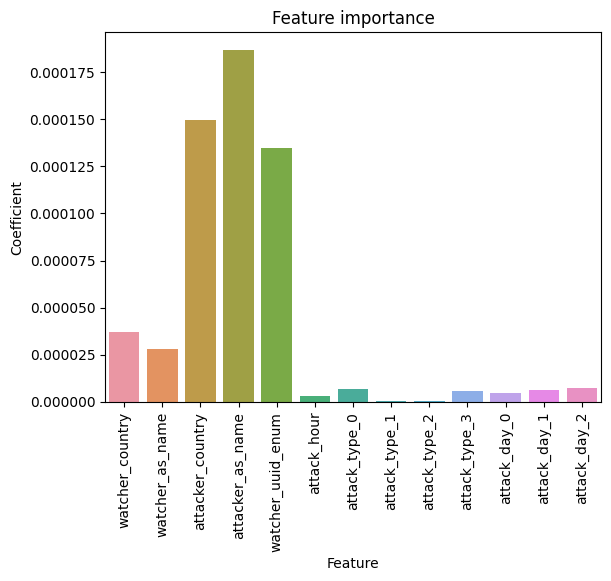

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=fidf,
            x='features',
            y='coefs')

plt.title("Feature importance")
plt.xlabel("Feature")
plt.xticks(rotation=90)
plt.ylabel("Coefficient")

### Kaggle submission

In [ ]:
#del train_df, test_df, X_train, y_train, X_test, y_test
gc.collect()

test_df = pq.read_table('test_encoded.parq').to_pandas().dropna()
X_kaggle = test_df.drop(['attacker_ip_enum', 'attacker_as_num', 'watcher_as_num'], axis=1)
ip_kaggle = test_df['attacker_ip_enum']

y_kaggle = clf.predict(X_kaggle)

submission = pd.DataFrame({'attacker_ip_enum': ip_kaggle, 'prediction': y_kaggle})

# submission.to_parquet('submission.parq')

In [ ]:
submission['attacker_ip_enum'] = submission['attacker_ip_enum'].astype('int32')
submission['prediction'] = submission['prediction'].astype('int8')


In [ ]:
submission = submission.groupby('attacker_ip_enum').mean().reset_index()
submission['prediction'] = submission['prediction'].round().astype(int)

In [ ]:
submission.set_index('attacker_ip_enum').to_csv('preceptron_submission.csv')

In [ ]:
submission.info()

# Conclussions stage

> Val score: 0.54175
>
> Test (Kaggle) Score: 0.51895